In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import glob
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from functools import reduce
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import optuna
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

from tqdm import tqdm
from collections import defaultdict
from itertools import combinations

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from pytorch_tabnet.tab_network import TabNetEncoder

In [ ]:
seed = 810

def set_seed(sd):
    random.seed(sd)
    np.random.seed(sd)
    os.environ['PYTHONHASHSEED'] = str(sd)
    random.seed(sd)
    np.random.seed(sd)
    torch.manual_seed(sd)
    torch.cuda.manual_seed_all(sd)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

In [ ]:
data_dir = '/content/drive/MyDrive/1데이콘/ETRI_휴먼이해_인공지능/ETRI_lifelog_dataset/'

In [ ]:
prep_df = pd.read_csv(data_dir + 'prep_df.csv')
metrics_train = pd.read_csv(data_dir + 'ch2025_metrics_train.csv')
sample_submission = pd.read_csv(data_dir + 'ch2025_submission_sample.csv')

# train/test 데이터셋

In [ ]:
# datetime 형으로 변환
metrics_train['lifelog_date'] = pd.to_datetime(metrics_train['lifelog_date']).dt.date
prep_df['date'] = pd.to_datetime(prep_df['date']).dt.date
# prep_df.loc[:, 'date'] = pd.to_datetime(prep_df.loc[:, 'date']).dt.date

In [ ]:
# train_df
metrics_train_renamed = metrics_train.rename(columns = {'lifelog_date': 'date'})

train_df = pd.merge(metrics_train_renamed, prep_df, on=['subject_id', 'date'], how='inner')
print(train_df.shape)

(450, 164)


In [ ]:
# test_df
prep_key = prep_df[['subject_id','date']]
train_key = metrics_train_renamed[['subject_id','date']]

prep_train_key = pd.merge(prep_key, train_key, on=['subject_id','date'], how='left', indicator=True)
test_key = prep_train_key[prep_train_key['_merge'] == 'left_only'].drop(columns=['_merge'])
print(test_key.shape)

test_df = pd.merge(test_key, prep_df, on=['subject_id','date'], how='left')
print(test_df.shape)

(250, 2)
(250, 157)


In [ ]:
x = train_df.drop(columns=['subject_id', 'sleep_date', 'date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3'])
x.fillna(0, inplace=True)

y = train_df[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]
y.fillna(0, inplace=True)

test_x = test_df.drop(columns=['subject_id', 'date'])
test_x.fillna(0, inplace=True)

In [ ]:
def clear_columns_names(df):
  df.columns = (df.columns
                .str.replace(r"[^\w]", "_", regex=True)
                .str.replace(r'__+','_', regex=True)
                .str.strip('_')
                )
  return df

x = clear_columns_names(x)
test_x = clear_columns_names(test_x)

x = x.select_dtypes(include=['number','bool','category'])
test_x = test_x[x.columns]

In [ ]:
# 컬럼 확인
def find_duplicate(df):
  return df.columns[df.columns.duplicated()].tolist()

dup_x = find_duplicate(x)
dup_test_x = find_duplicate(test_x)
print('x_중복컬럼:', dup_x)
print('test_x_중복컬럼:', dup_test_x)

# 컬럼 집합
x_columns = set(x.columns)
test_x_columns = set(test_x.columns)

only_x = x_columns - test_x_columns
only_test_x = test_x_columns - x_columns
print('only_x:', only_x)
print('only_x_test:', only_test_x)

x_중복컬럼: []
test_x_중복컬럼: []
only_x: set()
only_x_test: set()


# Seq2seq(GRU) + Attention

In [ ]:
targets = ['Q1','Q2','Q3','S1','S2','S3']

class SeqDataset_train(Dataset):
    def __init__(self, df, targets):
        # self.samples = []
        # self.seq_len = seq_len
        self.targets = targets
        self.feature_cols = [col for col in df.columns if col not in ['subject_id', 'date', 'sleep_date', 'lifelog_date'] + targets]

        self.x = df[self.feature_cols].to_numpy(dtype=np.float32)
        self.y = df[targets].to_numpy(dtype=np.float32)

        # for sub, group in df.groupby('subject_id'):
        #     group = group.sort_values('date').reset_index(drop=True)
        #     max_i = len(group) - seq_len - 1
        #     for i in range(max_i + 1):
        #         x_seq = group.iloc[i:i+seq_len][self.feature_cols].to_numpy(dtype=np.float32)
        #         y = group.iloc[i+seq_len][self.targets].to_numpy(dtype=np.float32)
        #         self.samples.append((x_seq, y))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
      return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])

class SeqDataset_test(Dataset):
    def __init__(self, df, targets):
        # self.samples = []
        # self.seq_len = seq_len
        self.targest = targets
        self.feature_cols = [col for col in df.columns if col not in ['subject_id', 'date', 'sleep_date', 'lifelog_date'] + targets]
        self.x = df[self.feature_cols].to_numpy(dtype=np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.tensor(self.x[idx])

class FeatureAttention(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        weights = self.attention(x)          # (batch, input_dim)
        return x * weights

class Encoder(nn.Module):
  # Numeric
  def __init__(self, input_dim, hidden_dim, num_layers, dropout):
    super().__init__()
    self.num_layers = num_layers
    self.gru = nn.GRU(input_dim,
                      hidden_dim,
                      num_layers,
                      batch_first=True,
                      dropout = dropout if num_layers > 1 else 0)

  def forward(self, src):
    encoder_outputs, hidden = self.gru(src)

    return encoder_outputs, hidden

class Attention(nn.Module):
  # Luong
  def __init__(self, hidden_dim):
    super().__init__()
    self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
    self.v = nn.Linear(hidden_dim, 1, bias=False)

  def forward(self, hidden, encoder_outputs):
    src_len = encoder_outputs.size(1)
    hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
    concat = torch.cat((hidden, encoder_outputs), dim=2)
    atten = self.attn(concat)
    energy = torch.tanh(atten)
    # energy = torch.tanh(self.atten(torch.cat((hidden, encoder_outputs), dim=2)))
    attention = self.v(energy).squeeze(2)

    return torch.softmax(attention, dim=1)

class Decoder(nn.Module):
  #Multi
  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers, attention, dropout):
    super().__init__()
    self.embedding = nn.Linear(input_dim, embedding_dim)
    self.gru = nn.GRU(hidden_dim + embedding_dim,
                      hidden_dim,
                      num_layers,
                      batch_first=True,
                      dropout = dropout if num_layers > 1 else 0)
    self.fc_out = nn.Linear(hidden_dim * 2 + embedding_dim, output_dim)
    self.attention = attention
  def forward(self, input, hidden, encoder_outputs):
    embedded = self.embedding(input).unsqueeze(1)
    hidden_ = hidden.squeeze(0)
    attn_weights = self.attention(hidden_, encoder_outputs).unsqueeze(1)
    context = torch.bmm(attn_weights, encoder_outputs)
    gru_input = torch.cat((embedded, context), dim=2)
    output, hidden = self.gru(gru_input, hidden)

    output = output.squeeze(1)
    context = context.squeeze(1)
    embedded = embedded.squeeze(1)

    prediction = self.fc_out(torch.cat((output, context, embedded), dim=1))

    return prediction, hidden, attn_weights.squeeze(1)

class seq2seqMulti(nn.Module):
  def __init__(self, encoder, decoder, feature_attn, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.feature_attn = feature_attn
    self.device = device

  def forward(self, src):
    src = self.feature_attn(src)
    src = src.unsqueeze(1)
    encoder_outputs, hidden = self.encoder(src)

    input_last = src[:, -1, :]
    decoder_output, _, _ = self.decoder(input_last, hidden, encoder_outputs)

    return decoder_output

In [ ]:
def find_threshold(model, train_dataset, optimizer, bce_loss_fn, ce_loss_fn, batch_size, device):
    model.train()
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    thresholds = np.linspace(0.1, 1, 10)
    f1_scores_per_threshold = [[] for _ in thresholds]

    for e in range(1, 10  + 1):
      train_loss = 0
      train_accuracy = 0

      for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        output = model(x_batch)
        # Q1 ~ Q3, S2 ~ S3 - binary
        binary_logits = torch.cat([output[:, 0:3], output[:, 6:8]], dim=1)
        binary_target = torch.cat([y_batch[:, 0:3], y_batch[:, 4:6]], dim=1).float()
        loss_bce = bce_loss_fn(binary_logits, binary_target)

        sigmoid_output = torch.sigmoid(binary_logits)
        for i, t in enumerate(thresholds):
          binary_pred = (sigmoid_output > t).int()
          f1 = f1_score(binary_target, binary_pred, average='weighted', zero_division=0)
          f1_scores_per_threshold[i].append(f1)

        loss_bce.backward()
        optimizer.step()
        train_loss += loss_bce.item()

      avg_loss = train_loss / len(loader)

      if e % 10 == 0 or e == 1 or e == num_epochs:
        print(f'Epoch {e}/{num_epochs}, Loss: {avg_loss:.4f}')

    avg_f1_scores = [np.mean(scores) for scores in f1_scores_per_threshold]
    best_f1 = max(avg_f1_scores)
    best_threshold = thresholds[avg_f1_scores.index(best_f1)]
    print(f"최적의 임계값: {best_threshold:.2f}, F1 Score: {best_f1:.4f}")
    f1_matrix = np.array(f1_scores_per_threshold).T
    avg_f1_scores = f1_matrix.mean(axis=0)
    plt.plot(thresholds, avg_f1_scores)
    plt.title("F1 Score vs. Sigmoid Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    return best_threshold

In [ ]:
def train(model, train_dataset, optimizer, bce_loss_fn, ce_loss_fn, batch_size, bt, device):
    model.train()
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    train_loss = 0
    train_accuracy = 0

    for x_batch, y_batch in loader:
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      optimizer.zero_grad()

      output = model(x_batch)
      # Q1 ~ Q3, S2 ~ S3 - binary
      binary_logits = torch.cat([output[:, 0:3], output[:, 6:8]], dim=1)
      binary_target = torch.cat([y_batch[:, 0:3], y_batch[:, 4:6]], dim=1).float()
      loss_bce = bce_loss_fn(binary_logits, binary_target)

      binary_pred = (torch.sigmoid(binary_logits) > bt).int()
      binary_correct = (binary_pred == binary_target).sum().item()
      binary_total = binary_target.numel()
      binary_acc = binary_correct / binary_total

      # S1 - multi
      multi_logits = output[:, 3:6]
      multi_target = y_batch[:, 3].long()
      loss_ce = ce_loss_fn(multi_logits, multi_target)

      multi_pred = multi_logits.argmax(dim=1)
      multi_correct = (multi_pred == multi_target).sum().item()
      multi_acc = multi_correct / x_batch.size(0)

      loss = loss_bce + loss_ce
      accuracy = (binary_acc + multi_acc) / 2

      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      train_accuracy += accuracy

    # avg_loss = train_loss / len(loader)
    # avg_accuracy = train_accuracy / len(loader)

    return train_loss, train_accuracy

def predict(model, test_df, sample_submission, seq_len):
    model.eval()
    all_preds = []

    loader = DataLoader(test_df, batch_size=batch_size, shuffle=False)

    for batch in loader:
      x_batch = batch.to(device)
      with torch.no_grad():
        logits = model(x_batch).squeeze(0)

        # Q1~Q3, S2~S3: binary -> sigmoid > 0.5
        binary_logits = torch.cat([logits[:, 0:3], logits[:, 6:8]], dim=1)
        binary_pred = (torch.sigmoid(binary_logits) > bt).int()

        # S1: multiclass (3 classes -> softmax + argmax)
        multi_logits = logits[:, 3:6]
        multi_class = torch.argmax(torch.softmax(multi_logits, dim=1), dim=1).unsqueeze(1)

        final_pred = torch.cat([binary_pred[:, :3], multi_class, binary_pred[:, 3:]], dim=1)
        all_preds.extend(final_pred.cpu().tolist())


    all_preds = np.array(all_preds)
    submission_out = sample_submission.copy()
    submission_out[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']] = all_preds

    return submission_out

In [ ]:
# 모델 파라미터 설정
input_dim = 155
embedding_dim = 64
hidden_dim = 128
output_dim = 8  # Q1~Q3,S2~S3 = 1 , S1 = 3
num_layers = 1
lr = 1e-4
batch_size = 16
attention = Attention(hidden_dim)
seq_len = 1
dropout = 0.2
num_epochs = 10

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

train_df = train_df.fillna(0)
teset_df = test_df.fillna(0)

encoder = Encoder(input_dim, hidden_dim, num_layers, dropout)
attn = Attention(hidden_dim)
feature_attn = FeatureAttention(input_dim)
decoder = Decoder(input_dim, embedding_dim, hidden_dim, output_dim, num_layers, attention, dropout)

model = seq2seqMulti(encoder, decoder, feature_attn, device)

bce_loss_fn = nn.BCEWithLogitsLoss()
ce_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_df_pt = SeqDataset_train(train_df, targets)
test_df_pt = SeqDataset_test(test_df, targets)

Epoch 1/10, Loss: 83154.6028
Epoch 10/10, Loss: 4258.8713
최적의 임계값: 0.10, F1 Score: 0.5348


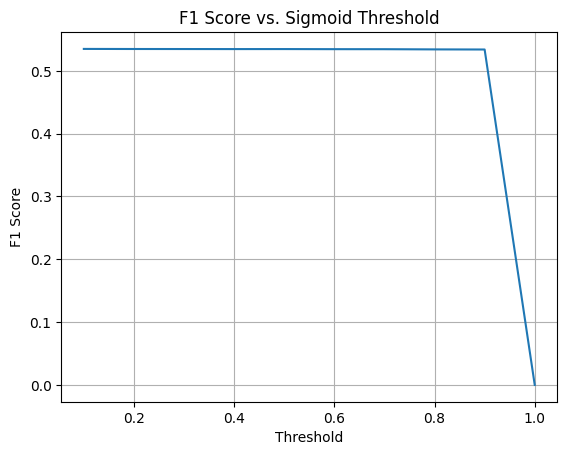

In [ ]:
bt = find_threshold(model, train_df_pt, optimizer, bce_loss_fn, ce_loss_fn, batch_size, device)

In [ ]:
# from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# ss_col = [col for col in train_df.columns if col not in ['subject_id', 'date', 'sleep_date', 'lifelog_date'] + targets]
# train_df[ss_col] = ss.fit_transform(train_df[ss_col].values)
# test_df[ss_col] = ss.transform(test_df[ss_col].values)

In [ ]:
epochloop = tqdm(range(num_epochs), desc='Training')

for e in epochloop:
    train_loss, train_accuracy = train(model, train_df_pt, optimizer, bce_loss_fn, ce_loss_fn, batch_size, bt, device)
    epochloop.write(f'Epoch[{e+1}/{num_epochs}] Train Loss: {train_loss / len(train_df_pt):.4f} Train Acc: {train_accuracy / len(train_df_pt)}')

Training:  10%|█         | 1/10 [00:00<00:04,  1.89it/s]

Epoch[1/10] Train Loss: 3848.2827 Train Acc: 0.030013888888888885


Training:  20%|██        | 2/10 [00:00<00:03,  2.19it/s]

Epoch[2/10] Train Loss: 2607.5921 Train Acc: 0.0315


Training:  30%|███       | 3/10 [00:01<00:03,  2.22it/s]

Epoch[3/10] Train Loss: 1639.6616 Train Acc: 0.029208333333333333


Training:  40%|████      | 4/10 [00:01<00:02,  2.18it/s]

Epoch[4/10] Train Loss: 1701.5665 Train Acc: 0.02945833333333333


Training:  50%|█████     | 5/10 [00:02<00:02,  2.35it/s]

Epoch[5/10] Train Loss: 1096.2806 Train Acc: 0.02923611111111111


Training:  60%|██████    | 6/10 [00:02<00:01,  2.54it/s]

Epoch[6/10] Train Loss: 654.1899 Train Acc: 0.029513888888888888


Training:  70%|███████   | 7/10 [00:02<00:01,  2.81it/s]

Epoch[7/10] Train Loss: 729.4742 Train Acc: 0.028277777777777784


Training:  80%|████████  | 8/10 [00:03<00:00,  3.01it/s]

Epoch[8/10] Train Loss: 956.6756 Train Acc: 0.028624999999999998


Training:  90%|█████████ | 9/10 [00:03<00:00,  3.10it/s]

Epoch[9/10] Train Loss: 1277.2636 Train Acc: 0.028194444444444446


Training: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]

Epoch[10/10] Train Loss: 767.3623 Train Acc: 0.031222222222222228


In [ ]:
preds = predict(model, test_df_pt, sample_submission, seq_len)

# MLP

In [ ]:
targets = ['Q1','Q2','Q3','S1','S2','S3']

class MLPdataset_train(Dataset):
  def __init__(self, df, targets):
    self.targets = targets
    self.feature_cols = [col for col in df.columns if col not in ['subject_id', 'date', 'sleep_date', 'lifelog_date'] + targets]

    self.x = df[self.feature_cols].to_numpy(dtype=np.float32)
    self.y = df[targets].to_numpy(dtype=np.float32)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])

class MLPdataset_test(Dataset):
  def __init__(self, df, targets):
    self.targets = targets
    self.feature_cols = [col for col in df.columns if col not in ['subject_id', 'date', 'sleep_date', 'lifelog_date'] + targets]

    self.x = df[self.feature_cols].to_numpy(dtype=np.float32)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return torch.tensor(self.x[idx])


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout, device):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# 모델 파라미터 설정
input_dim = 181
hidden_dim = 128
output_dim = 9  # Q1~Q3,S2~S3 = 1 , S1 = 3
batch_size=32
lr = 1e-4
dropout = 0.2
num_epochs = 100

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

train_df = train_df.fillna(0)
teset_df = test_df.fillna(0)

model = MLP(input_dim, hidden_dim, output_dim, dropout, device)

bce_loss_fn = nn.BCEWithLogitsLoss()
ce_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
train_df_mlp = MLPdataset_train(train_df, targets)

train(model, train_df_mlp, optimizer, bce_loss_fn, ce_loss_fn, batch_size, device)

In [ ]:
test_df_mlp = MLPdataset_test(test_df, targets)

preds = predict(model, test_df_mlp, sample_submission, batch_size, device)

# MLP + TabNet

In [ ]:
class MLPwithTabNet(nn.Module):
  def __init__(self, input_dim, output_dim, tabnet_dim, mlp_hidden_dim, n_steps, dropout, device):
    super().__init__()

    self.tabnet = TabNetEncoder(
        input_dim=input_dim,
        output_dim=tabnet_dim,
        n_d=tabnet_dim,
        n_a=tabnet_dim,
        n_steps=n_steps,
        n_shared=2,
        n_independent=2,
        virtual_batch_size=64,
        momentum=0.02
        # cat_idxs=[],
        # cat_dims=[],
        # cat_emb_dim=1
    )

    self.mlp = nn.Sequential(
        nn.Linear(tabnet_dim, mlp_hidden_dim),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_hidden_dim, mlp_hidden_dim),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_hidden_dim, 64),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(64, output_dim)
        )

  def forward(self, x):
    tabnet_out, _  = self.tabnet(x)
    tabnet_out = tabnet_out[-1]
    outputs = self.mlp(tabnet_out)
    return outputs

In [ ]:
def train(model, train_dataset, optimizer, bce_loss_fn, ce_loss_fn, batch_size, device):
    model.train()
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for e in range(1, num_epochs + 1):
      train_loss = 0.0
      train_accuracy = 0.0
      for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        output = model(x_batch)
        print(output)
        # Q1 ~ Q3, S2 ~ S3 - binary
        binary_logits = torch.cat([output[:, 0:3], output[:, 6:8]], dim=1)
        binary_target = torch.cat([y_batch[:, 0:3], y_batch[:, 4:6]], dim=1).float()
        loss_bce = bce_loss_fn(binary_logits, binary_target)

        binary_pred = (torch.sigmoid(torch.cat([output[:, 0:3], output[:, 6:8]], dim=1)) > 0.5).int()
        binary_correct = (binary_pred == binary_target).sum().item()
        binary_total = binary_target.numel()
        binary_acc = binary_correct / binary_total

        # S1 - multi
        multi_logits = output[:, 3:6]
        multi_target = y_batch[:, 3].long()
        loss_ce = ce_loss_fn(multi_logits, multi_target)

        multi_pred = multi_logits.argmax(dim=1)
        multi_correct = (multi_pred == multi_target).sum().item()
        multi_acc = multi_correct / x_batch.size(0)

        loss = loss_bce + loss_ce
        accuracy = (binary_acc + multi_acc) / 2

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_accuracy += accuracy

      avg_loss = train_loss / len(loader)
      avg_accuracy = train_accuracy / len(loader)

      if e % 10 == 0 or e == 1 or e == num_epochs:
        print(f'Epoch {e}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

def predict(model, test_df, sample_submission, batch_size, device):
    model.eval()
    all_preds = []

    loader = DataLoader(test_df, batch_size=batch_size, shuffle=False)

    for batch in loader:
      x_batch = batch.to(device)
      with torch.no_grad():
        logits = model(x_batch)

        # Q1~Q3, S2~S3: binary -> sigmoid > 0.5
        binary_logits = torch.cat([logits[:, 0:3], logits[:, 6:8]], dim=1)
        binary_pred = (torch.sigmoid(binary_logits) > 0.5).int()

        # S1: multiclass (3 classes -> softmax + argmax)
        multi_logits = logits[:, 3:6]
        multi_class = torch.argmax(torch.softmax(multi_logits, dim=1), dim=1).unsqueeze(1)

        final_pred = torch.cat([binary_pred[:, :3], multi_class, binary_pred[:, 3:]], dim=1)
        all_preds.extend(final_pred.cpu().tolist())

    all_preds = np.array(all_preds)
    submission_out = sample_submission.copy()
    submission_out[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']] = all_preds

    return submission_out

In [ ]:
# 모델 파라미터 설정
input_dim = 181
mlp_hidden_dim = 128
output_dim = 8 # Q1~Q3,S2~S3 = 1 , S1 = 3
tabnet_dim = 64
n_steps = 5
dropout = 0.2
batch_size = 10
num_epochs = 50

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

train_df = train_df.fillna(0)
teset_df = test_df.fillna(0)

bce_loss_fn = nn.BCEWithLogitsLoss()
ce_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
model = MLPwithTabNet(input_dim, output_dim, tabnet_dim, mlp_hidden_dim, n_steps, dropout, device)

In [ ]:
train(model, train_df_mlp, optimizer, bce_loss_fn, ce_loss_fn, batch_size, device)

# MLP-Mixer

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.block(x)

class MLPMixer(nn.Module):
    def __init__(self, input_dim, num_layers=2, token_mlp_dim=64, channel_mlp_dim=128, output_dim=6):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, input_dim)

        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(input_dim),
                MLPBlock(input_dim, token_mlp_dim),
                nn.LayerNorm(input_dim),
                MLPBlock(input_dim, channel_mlp_dim)
            )
            for _ in range(num_layers)
        ])

        self.classifier = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, output_dim)
        )

    def forward(self, x):
        x = self.input_proj(x)

        for layer in self.layers:
            norm1, token_mlp, norm2, channel_mlp = layer
            x = x + token_mlp(norm1(x))
            x = x + channel_mlp(norm2(x))

        return self.classifier(x)


# 결과 저장

In [ ]:
final = sample_submission[['subject_id','sleep_date','lifelog_date']].copy()
final['lifelog_date'] = pd.to_datetime(final['lifelog_date']).dt.date

final['id'] = final['subject_id'] + '_' + final['lifelog_date'].astype(str)
assert len(final) == len(preds['S1'])

target_list = ['Q1', 'Q2', 'Q3', 'S1','S2','S3']
for col in target_list:
  final[col] = preds[col].astype(int)

submission_final = final[['subject_id','sleep_date','lifelog_date', 'Q1','Q2','Q3','S1','S2','S3']]
submission_final.to_csv('submission_final.csv',index=False)

from google.colab import files
files.download("submission_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>